In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/'My Drive'/'Colab Notebooks'/
%ls

/content/drive/My Drive/Colab Notebooks
 EDA.ipynb                       summary12_right_C.csv
 equipment_A.csv                 summary12_right_D.csv
 equipment_B.csv                 summary15_A.csv
 equipment_C.csv                 summary15_B.csv
 equipment_D.csv                 summary15_C.csv
 index_master.csv                summary15_D.csv
'model1 (1).ipynb'               summary18_A.csv
'model1 (1).ipynb のコピー'      summary18_B.csv
 model11.ipynb                   summary18_C.csv
 model12.ipynb                   summary18_D.csv
 model12_refine_CD.ipynb         summary19_A.csv
 model12_refine.ipynb            summary19_B.csv
 model12_refine_level_CD.ipynb   summary19_C.csv
 model12_refine_level.ipynb      summary19_D.csv
 model12_refine_right_CD.ipynb   summary4_A.csv
 model12_refine_right.ipynb      summary4_B.csv
 model15_CD.ipynb                summary4_C.csv
 model15.ipynb                   summary4_D.csv
 model18_C.ipynb                 summary4_refine_A.csv
 model18.ipynb    

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
tracks={}
for no in ['A','B','C','D']:
    tracks[no] = pd.read_csv("track_" + no + ".csv",
                             usecols=['date', 'キロ程', '高低左'],
                             parse_dates=["date"])

In [0]:
import datetime
from tqdm import tqdm
import random
import sys

In [0]:
def get_day(dates):
    day = [(date - datetime.datetime(2017, 4, 1)).days for date in dates]
    return np.array(day)

In [0]:
def feature_engineering(df, dmm, mv, admm):
    if dmm:
         df['diff_moving_mean'] = df['高低左'] - df['高低左'].rolling(window=7, min_periods=1, center=True).median()
    if mv:
        df['moving_variance'] = df['高低左'].rolling(window=7, min_periods=1, center=True).kurt()
    if admm:
        df['accumulation_diff_moving_mean'] = np.cumsum(
            abs(df['高低左'].rolling(window=3, min_periods=1, center=True).median() -
                df['高低左'].rolling(window=15, min_periods=1, center=False).median()))
    return df

In [0]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [0]:
def scaling(df, w1, w2, w3, w4):
    df['day'] = ss.fit_transform(df['day'].astype(float).values.reshape(len(df), 1))
    if w1 != 0:
        df['高低左'] = ss.fit_transform(df['高低左'].values.reshape(len(df), 1))*w1
    if w2 != 0:
        df['diff_moving_mean'] = ss.fit_transform(df['diff_moving_mean'].values.reshape(len(df), 1))*w2
    if w3 != 0:
        df['moving_variance'] = df['moving_variance'].fillna(0) #rollingした高低左が全部同じ値のときはNANになる
        df['moving_variance'] = ss.fit_transform(df['moving_variance'].values.reshape(len(df), 1))*w3
    if w4 != 0:
        df['accumulation_diff_moving_mean'] = \
        ss.fit_transform(df['accumulation_diff_moving_mean'].values.reshape(len(df), 1))*w4
    return df

In [0]:
from sklearn.neighbors import KernelDensity
bandwidth = [0.1, 1, 10, 50, 100]
kernel = ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine']
metric = ['minkowski', 'cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
leaf_size = [10, 40, 400, 4000]
kd = KernelDensity(bandwidth=bandwidth[3], kernel=kernel[0], metric=metric[0], leaf_size=leaf_size[1])

In [0]:
def kd_outliers(raw):
    df = raw.copy()
    df = feature_engineering(df, True, True, True)
    df = scaling(df, 50, 50, 0.5, 50)
    kd.fit(df)
    score_pred = kd.score_samples(df)
    normal_id = df[np.where(score_pred <= np.average(score_pred)*0.99999, False, True)].index.values
    return normal_id

In [0]:
def kd_outliers1(raw):
    df = raw.copy()
    df = feature_engineering(df, True, True, True)
    df = scaling(df, 50, 50, 0.5, 50)
    kd.fit(df)
    score_pred = kd.score_samples(df)
    normal_id = df[np.where(score_pred <= np.average(score_pred)*0.999, False, True)].index.values
    return normal_id

In [0]:
def kd_outliers2(raw):
    df = raw.copy()
    df = feature_engineering(df, True, True, True)
    df = scaling(df, 50, 50, 0.5, 50)
    kd.fit(df)
    score_pred = kd.score_samples(df)
    normal_id = df[np.where(score_pred <= np.average(score_pred)*0.99998, False, True)].index.values
    return normal_id

In [0]:
from scipy.cluster.hierarchy import linkage, fcluster

In [0]:
def dendrogram_outliers(raw):
    df = raw.copy()
    df = feature_engineering(df, True, False, True)
    df = scaling(df, 10, 50, 0, 100)

    linkage_result = linkage(df, method='ward', metric='euclidean')
    threshold = 0.95 * np.max(linkage_result[:, 2])
    clustered = fcluster(linkage_result, threshold, criterion='distance')

    df['label'] = clustered
    normal_label = df['label'].mode()[0]
    normal_id = df[df['label'] == normal_label].index.values
    return normal_id

In [0]:
def remove_outliers(raw):
    local_global = [[[], []], [[], []], [[], []], [[], []]]
    local_global[0][1].extend(raw.index.values)
    df1 = raw.copy()
    local_global[1][1].extend(kd_outliers(df1))

    df2 = raw.loc[local_global[1][1]]
    df2 = df2.reset_index(drop=True)
    local_global[2][0].extend(dendrogram_outliers(df2))
    local_global[2][1].extend([local_global[1][1][i] for i in local_global[2][0]])

    df3 = raw.loc[local_global[2][1]]
    df3 = df3.reset_index(drop=True)
    local_global[3][0].extend(kd_outliers2(df3))
    local_global[3][1].extend([local_global[2][1][i] for i in local_global[3][0]])
    return local_global[3][1]

def flag_outliers(raw):
    local_global = [[[], []], [[], []], [[], []], [[], []]]
    local_global[0][1].extend(raw.index.values)
    df1 = raw.copy()
    local_global[1][1].extend(kd_outliers(df1))

    df2 = raw.loc[local_global[1][1]]
    df2 = df2.reset_index(drop=True)
    local_global[2][0].extend(dendrogram_outliers(df2))
    local_global[2][1].extend([local_global[1][1][i] for i in local_global[2][0]])

    df3 = raw.loc[local_global[2][1]]
    df3 = df3.reset_index(drop=True)
    local_global[3][0].extend(kd_outliers2(df3))
    local_global[3][1].extend([local_global[2][1][i] for i in local_global[3][0]])

    out1 = set(local_global[0][1]) - set(local_global[1][1])
    out2 = set(local_global[1][1]) - set(local_global[2][1])
    out3 = set(local_global[2][1]) - set(local_global[3][1])
    normal = local_global[3][1]
    return out1, out2, out3, normal

fig, axes = plt.subplots(50, 1, figsize=(15, 100), sharex=True)
random.seed(110)
track = tracks['C']
kilos = track['キロ程'].unique()

for i, kilo in enumerate(random.sample(list(kilos), 50)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    if len(data) < 20:
        print(i)
        continue
    out1, out2, out3, normal = flag_outliers(data)

    datao1 = data.loc[out1]
    datao2 = data.loc[out2]
    datao3 = data.loc[out3]
    datal = data.loc[normal]

    axes[i].plot(datao1['day'], datao1['高低左'], marker='.', linewidth=0, c='c')
    axes[i].plot(datao2['day'], datao2['高低左'], marker='.', linewidth=0, c='g')
    axes[i].plot(datao3['day'], datao3['高低左'], marker='.', linewidth=0, c='r')
    axes[i].plot(datal['day'], datal['高低左'], marker='.', linewidth=0, c='b')

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [0]:
def get_slope_variance(X, y):
    if len(X) < 10:
        slope = 100
        variance = 100
    else:
        data = np.array([X, y]).T
        pca.fit(data)
        cmp = pca.components_
        cov = pca.get_covariance()

        slope = cmp[0, 1] / cmp[0, 0]
        variance = cov[1, 1] / cov[0, 0]

    return slope, variance

In [0]:
def get_intercept(raw):
    data = raw.copy()
    if sum(data['date'] >= "2018-03-01") == 0:
#        print('sum(data["date"] >= "2018-03-01") == 0')
        intercept = np.median(data['高低左'].values[-10:])

    else:
        data = data.loc[data['date'] >= "2018-03-01"]
        data = data.reset_index(drop=True)
        data = data.drop('date', axis=1)
        if len(data) < 4:
 #           print('sum(data["date"] >= "2018-03-01") < 4')
            intercept = np.median(data['高低左'].values)

        else:
            normal_id = kd_outliers1(data)
            data = data.loc[normal_id]
            intercept = np.median(data['高低左'].values)

    return intercept

In [0]:
summarys12_left = {}
for no in ['A', 'B', 'C', 'D']:
    summarys12_left[no] = pd.read_csv(f'summary12_refine_{no}.csv', index_col=0)

In [0]:
summarys12_right = {}
for no in ['A', 'B', 'C', 'D']:
    summarys12_right[no] = pd.read_csv(f'summary12_right_{no}.csv', usecols=['傾き'])

In [0]:
summarys4_left = {}
for no in ['A', 'B', 'C', 'D']:
    summarys4_left[no] = pd.read_csv(f'summary4_refine_{no}.csv', usecols=['傾き'])

In [0]:
summarys4_right = {}
for no in ['A', 'B', 'C', 'D']:
    summarys4_right[no] = pd.read_csv(f'summary4_refine_right_{no}.csv', usecols=['傾き'])

In [0]:
summarys5_left = {}
for no in ['A', 'B', 'C', 'D']:
    summarys5_left[no] = pd.read_csv(f'summary5_refine_{no}.csv', usecols=['傾き'])

In [0]:
summarys5_right = {}
for no in ['A', 'B', 'C', 'D']:
    summarys5_right[no] = pd.read_csv(f'summary5_refine_right_{no}.csv', usecols=['傾き'])

In [0]:
for no in ['A', 'B', 'C', 'D']:
    summarys12_left[no].loc[summarys12_left[no]['傾き'] == 100, '傾き'] = \
    np.median(summarys12_left[no].loc[summarys12_left[no]['傾き'].notnull(), '傾き'])
    summarys12_left[no].loc[summarys12_left[no]['分散比'] == 100, '分散比'] = \
    np.median(summarys12_left[no].loc[summarys12_left[no]['分散比'].notnull(), '分散比'])
    summarys12_left[no].loc[summarys12_left[no]['傾き'].isnull(), '傾き'] = \
    np.median(summarys12_left[no].loc[summarys12_left[no]['傾き'].notnull(), '傾き'])
    summarys12_left[no].loc[summarys12_left[no]['切片'].isnull(), '切片'] = \
    np.median(summarys12_left[no].loc[summarys12_left[no]['切片'].notnull(), '切片'])

In [0]:
for no in ['A', 'B', 'C', 'D']:
    summarys12_right[no].loc[summarys12_right[no]['傾き'] == 100, '傾き'] = \
    np.median(summarys12_right[no].loc[summarys12_right[no]['傾き'].notnull(), '傾き'])
    summarys12_right[no].loc[summarys12_right[no]['傾き'].isnull(), '傾き'] = \
    np.median(summarys12_right[no].loc[summarys12_right[no]['傾き'].notnull(), '傾き'])

In [0]:
for no in ['A', 'B', 'C', 'D']:
    summarys4_left[no].loc[summarys4_left[no]['傾き'] == 100, '傾き'] = \
    np.median(summarys4_left[no].loc[summarys4_left[no]['傾き'].notnull(), '傾き'])
    summarys4_left[no].loc[summarys4_left[no]['傾き'].isnull(), '傾き'] = \
    np.median(summarys4_left[no].loc[summarys4_left[no]['傾き'].notnull(), '傾き'])

In [0]:
for no in ['A', 'B', 'C', 'D']:
    summarys4_right[no].loc[summarys4_right[no]['傾き'] == 100, '傾き'] = \
    np.median(summarys4_right[no].loc[summarys4_right[no]['傾き'].notnull(), '傾き'])
    summarys4_right[no].loc[summarys4_right[no]['傾き'].isnull(), '傾き'] = \
    np.median(summarys4_right[no].loc[summarys4_right[no]['傾き'].notnull(), '傾き'])

In [0]:
for no in ['A', 'B', 'C', 'D']:
    summarys5_left[no].loc[summarys5_left[no]['傾き'] == 100, '傾き'] = \
    np.median(summarys5_left[no].loc[summarys5_left[no]['傾き'].notnull(), '傾き'])
    summarys5_left[no].loc[summarys5_left[no]['傾き'].isnull(), '傾き'] = \
    np.median(summarys5_left[no].loc[summarys5_left[no]['傾き'].notnull(), '傾き'])

In [0]:
for no in ['A', 'B', 'C', 'D']:
    summarys5_right[no].loc[summarys5_right[no]['傾き'] == 100, '傾き'] = \
    np.median(summarys5_right[no].loc[summarys5_right[no]['傾き'].notnull(), '傾き'])
    summarys5_right[no].loc[summarys5_right[no]['傾き'].isnull(), '傾き'] = \
    np.median(summarys5_right[no].loc[summarys5_right[no]['傾き'].notnull(), '傾き'])

In [0]:
from lightgbm import LGBMRegressor
lgb = LGBMRegressor()

In [0]:
for no in ['A', 'B', 'C', 'D']:
    train = pd.DataFrame(summarys12_left[no]['傾き'].copy())
    for i in range(30):
        train[f'lag{i+1}'] = train['傾き'].shift(i+1)

    X_train = train.drop(['傾き'], axis=1).values
    y_train = train['傾き'].values
    lgb.fit(X_train, y_train)
    train_pred = lgb.predict(X_train)
    summarys12_left[no]['傾き_lgbm'] = train_pred

In [0]:
for no in ['A', 'B', 'C', 'D']:
    train = pd.DataFrame(summarys12_right[no]['傾き'].copy())
    for i in range(30):
        train[f'lag{i+1}'] = train['傾き'].shift(i+1)

    X_train = train.drop(['傾き'], axis=1).values
    y_train = train['傾き'].values
    lgb.fit(X_train, y_train)
    train_pred = lgb.predict(X_train)
    summarys12_right[no]['傾き_lgbm'] = train_pred

In [0]:
for no in ['A', 'B', 'C', 'D']:
    train = pd.DataFrame(summarys4_left[no]['傾き'].copy())
    for i in range(30):
        train[f'lag{i+1}'] = train['傾き'].shift(i+1)

    X_train = train.drop(['傾き'], axis=1).values
    y_train = train['傾き'].values
    lgb.fit(X_train, y_train)
    train_pred = lgb.predict(X_train)
    summarys4_left[no]['傾き_lgbm'] = train_pred

In [0]:
for no in ['A', 'B', 'C', 'D']:
    train = pd.DataFrame(summarys4_right[no]['傾き'].copy())
    for i in range(30):
        train[f'lag{i+1}'] = train['傾き'].shift(i+1)

    X_train = train.drop(['傾き'], axis=1).values
    y_train = train['傾き'].values
    lgb.fit(X_train, y_train)
    train_pred = lgb.predict(X_train)
    summarys4_right[no]['傾き_lgbm'] = train_pred

In [0]:
for no in ['A', 'B', 'C', 'D']:
    train = pd.DataFrame(summarys5_left[no]['傾き'].copy())
    for i in range(30):
        train[f'lag{i+1}'] = train['傾き'].shift(i+1)

    X_train = train.drop(['傾き'], axis=1).values
    y_train = train['傾き'].values
    lgb.fit(X_train, y_train)
    train_pred = lgb.predict(X_train)
    summarys5_left[no]['傾き_lgbm'] = train_pred

In [0]:
for no in ['A', 'B', 'C', 'D']:
    train = pd.DataFrame(summarys5_right[no]['傾き'].copy())
    for i in range(30):
        train[f'lag{i+1}'] = train['傾き'].shift(i+1)

    X_train = train.drop(['傾き'], axis=1).values
    y_train = train['傾き'].values
    lgb.fit(X_train, y_train)
    train_pred = lgb.predict(X_train)
    summarys5_right[no]['傾き_lgbm'] = train_pred

In [0]:
summarys = {}
for no in ['A', 'B', 'C', 'D']:
    summarys[no] = summarys12_left[no].drop(['分散比', '測定回数', 'データ数'], axis=1)
    summarys[no]['傾き12右'] = summarys12_right[no]['傾き']
    summarys[no]['傾き12右_lgbm'] = summarys12_right[no]['傾き_lgbm']
    summarys[no]['傾き4左'] = summarys4_left[no]['傾き']
    summarys[no]['傾き4左_lgbm'] = summarys4_left[no]['傾き_lgbm']
    summarys[no]['傾き4右'] = summarys4_right[no]['傾き']
    summarys[no]['傾き4右_lgbm'] = summarys4_right[no]['傾き_lgbm']
    summarys[no]['傾き5左'] = summarys5_left[no]['傾き']
    summarys[no]['傾き5左_lgbm'] = summarys5_left[no]['傾き_lgbm']
    summarys[no]['傾き5右'] = summarys5_right[no]['傾き']
    summarys[no]['傾き5右_lgbm'] = summarys5_right[no]['傾き_lgbm']

In [0]:
summarys['A']

In [0]:
del summarys12_left, summarys12_right, summarys4_left, summarys4_right, summarys5_left, summarys5_right

In [0]:
from sklearn.metrics import mean_absolute_error

In [44]:
for no in tqdm(['A', 'B', 'D']):
    track = tracks[no]
    summary = summarys[no]
    summary['傾き_best'] = 0.
    kilos = summary['キロ程'].values#[:10]
#    for kilo in tqdm(kilos):
    for kilo in kilos:
        if kilo%1000 == 0:
            print(kilo)
        data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
        data = data.dropna()
        data = data.reset_index(drop=True)
        data['day'] = get_day(data['date'])
        data = data.drop(['date'], axis=1)
        slopes = summary.loc[summary['キロ程'] == kilo]
        slopes = slopes.drop(['路線', 'キロ程', '切片'], axis=1).values[0]
        errors = np.zeros_like(slopes)
        for i in range(4):
            tmp = data.loc[data['day'] >= i*91]
            tmp = tmp.loc[tmp['day'] < (i+1)*91]
            tmp = tmp.reset_index(drop=True)
            if len(tmp) < 5:
                continue
            normal_id = kd_outliers1(tmp)
            tmp = tmp.loc[normal_id]
            intercept = np.median(tmp['高低左'].values)
            for j, slope in enumerate(slopes):
                errors[j] += mean_absolute_error(tmp['高低左'].values,
                                                 [intercept + (day-46-91*i)*slope for day in tmp['day'].values]) * (i+1)
        summary.loc[summary['キロ程'] == kilo, '傾き_best'] = slopes[np.argmin(errors)]
    summary.to_csv(f'summary20_{no}.csv')

  0%|          | 0/3 [00:00<?, ?it/s]

10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000


 33%|███▎      | 1/3 [57:06<1:54:13, 3426.82s/it]

10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000


 67%|██████▋   | 2/3 [1:37:16<52:01, 3121.72s/it]

10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


100%|██████████| 3/3 [2:05:49<00:00, 2699.16s/it]


In [46]:
summarys['D'].head()

,路線,キロ程,傾き,切片,傾き_lgbm,傾き12右,傾き12右_lgbm,傾き4左,傾き4左_lgbm,傾き4右,傾き4右_lgbm,傾き5左,傾き5左_lgbm,傾き5右,傾き5右_lgbm,傾き_best
0,D,10000,-0.001744,-0.670,-0.000041,0.000415,0.000161,-0.002123,-0.002027,-0.002626,-0.002615,-0.000095,0.000536,-0.003976,-0.002944,-0.000095
1,D,10001,0.003181,-0.450,0.003812,-0.003045,-0.002188,-0.000351,-0.000263,-0.001131,-0.001415,0.006745,0.004384,-0.001665,-0.001691,-0.000263
2,D,10002,0.002455,0.340,0.002705,-0.000977,-0.001357,0.000283,0.000129,-0.000406,0.000121,-0.002842,-0.002182,0.003762,0.001919,0.000000
3,D,10003,0.001804,1.275,0.001715,0.002353,0.001434,0.000041,0.001165,0.002466,0.001608,0.004136,0.002201,0.002517,0.002607,0.000000
4,D,10004,0.003191,1.510,0.001611,0.005427,0.002692,0.003496,0.002312,0.001548,0.001488,0.002334,-0.000022,0.002976,0.003844,-0.000022


In [0]:
summarys = {}
for no in ['A', 'B', 'C', 'D']:
    summarys[no] = pd.read_csv(f'summary20_{no}.csv', index_col=0)

In [50]:
p = []
intercept_day = 15
for no in ['A', 'B', 'C', 'D']:
    summary = summarys[no]
    for i in range(91):
        day = summary['切片'].values + summary['傾き_best'].values*(i+intercept_day)
        p.extend(day)

submision = pd.DataFrame(p)
print(sum(submision.isnull()))
submision = submision.fillna(0)
submision = submision.apply(lambda x:x.round(2)) #サイズが大きいため予測値を桁落とし

A
B
C
D
0


In [51]:
submision.max()

0    18.45
dtype: float64

In [52]:
submision.min()

0   -19.28
dtype: float64

submision.loc[submision[0] > 16, 0] = 16
submision.loc[submision[0] < -16, 0] = -16

In [53]:
len(submision[submision[0] >= 16])
len(submision[submision[0] <= -16])

573

In [54]:
submision

,0
0,0.36
1,2.65
2,5.01
3,6.03
4,5.06
5,1.64
6,-3.14
7,-7.12
8,-8.84
9,-7.41


In [0]:
submision.to_csv("submit20.csv", header=None)

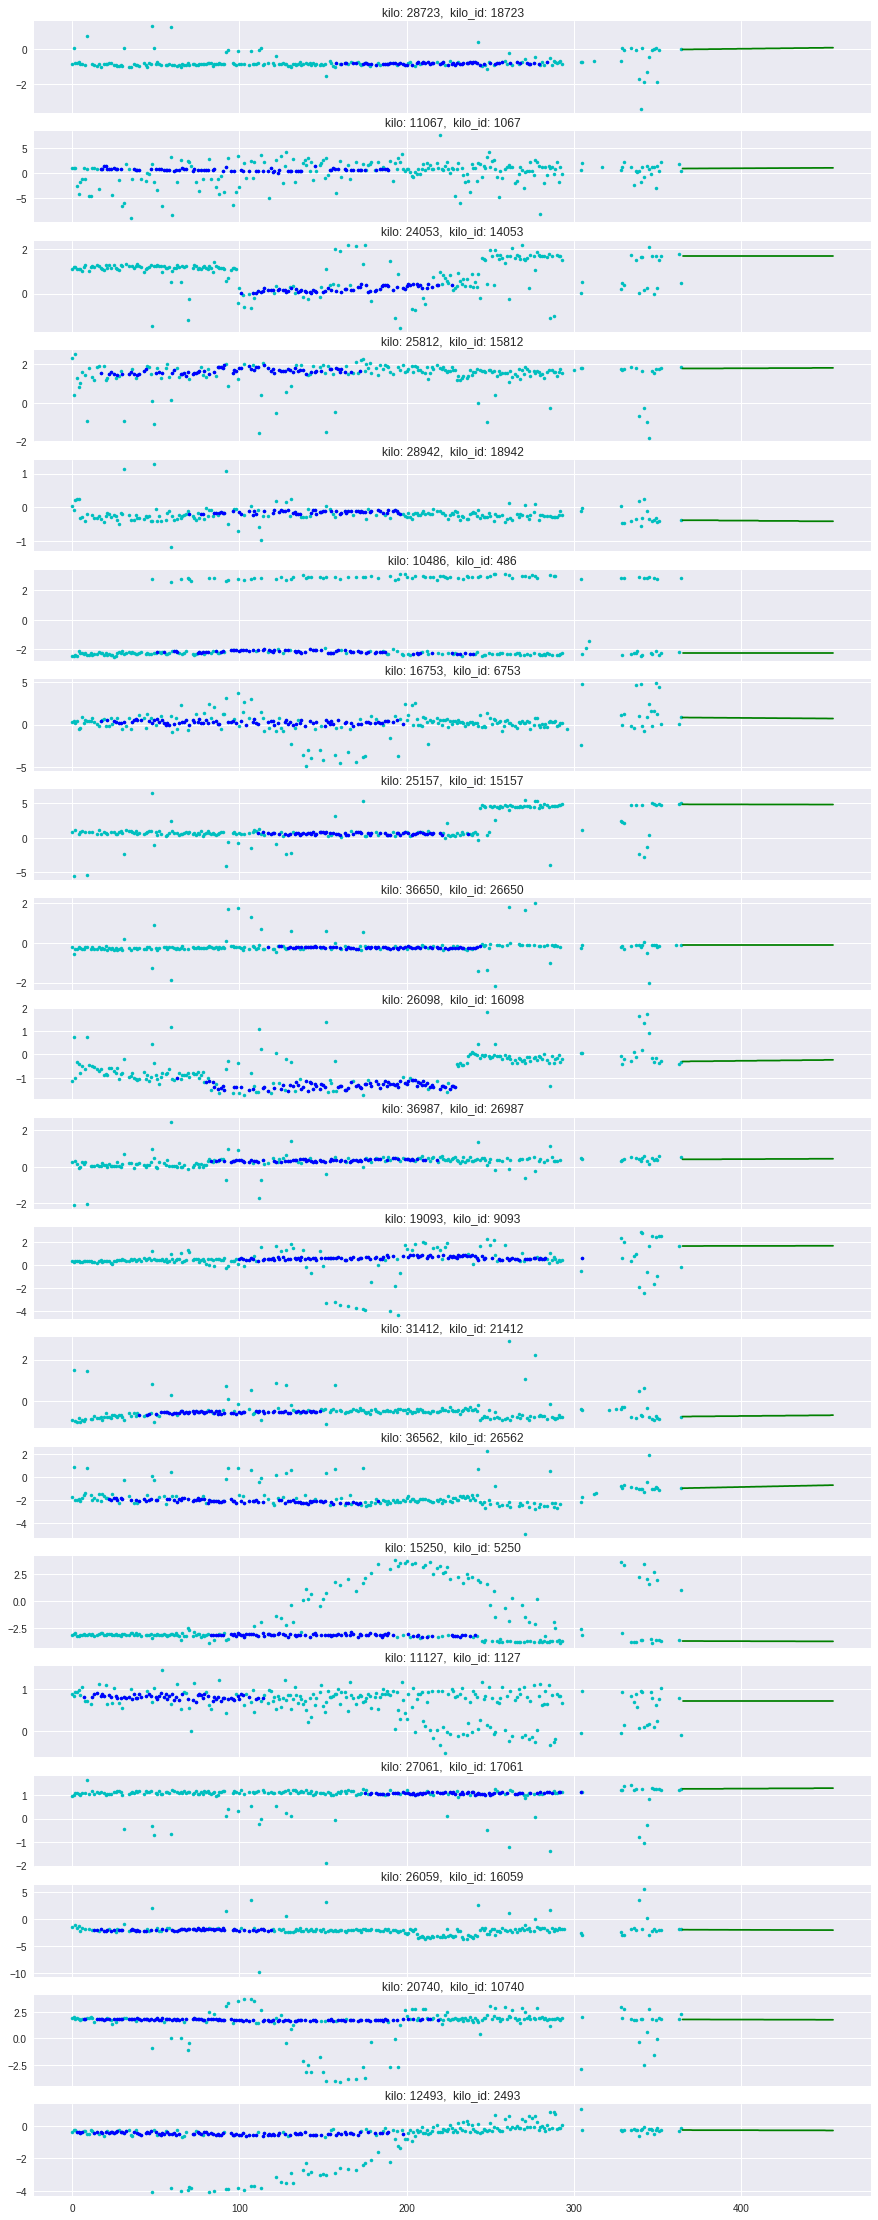

In [56]:
random.seed(10)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['A']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

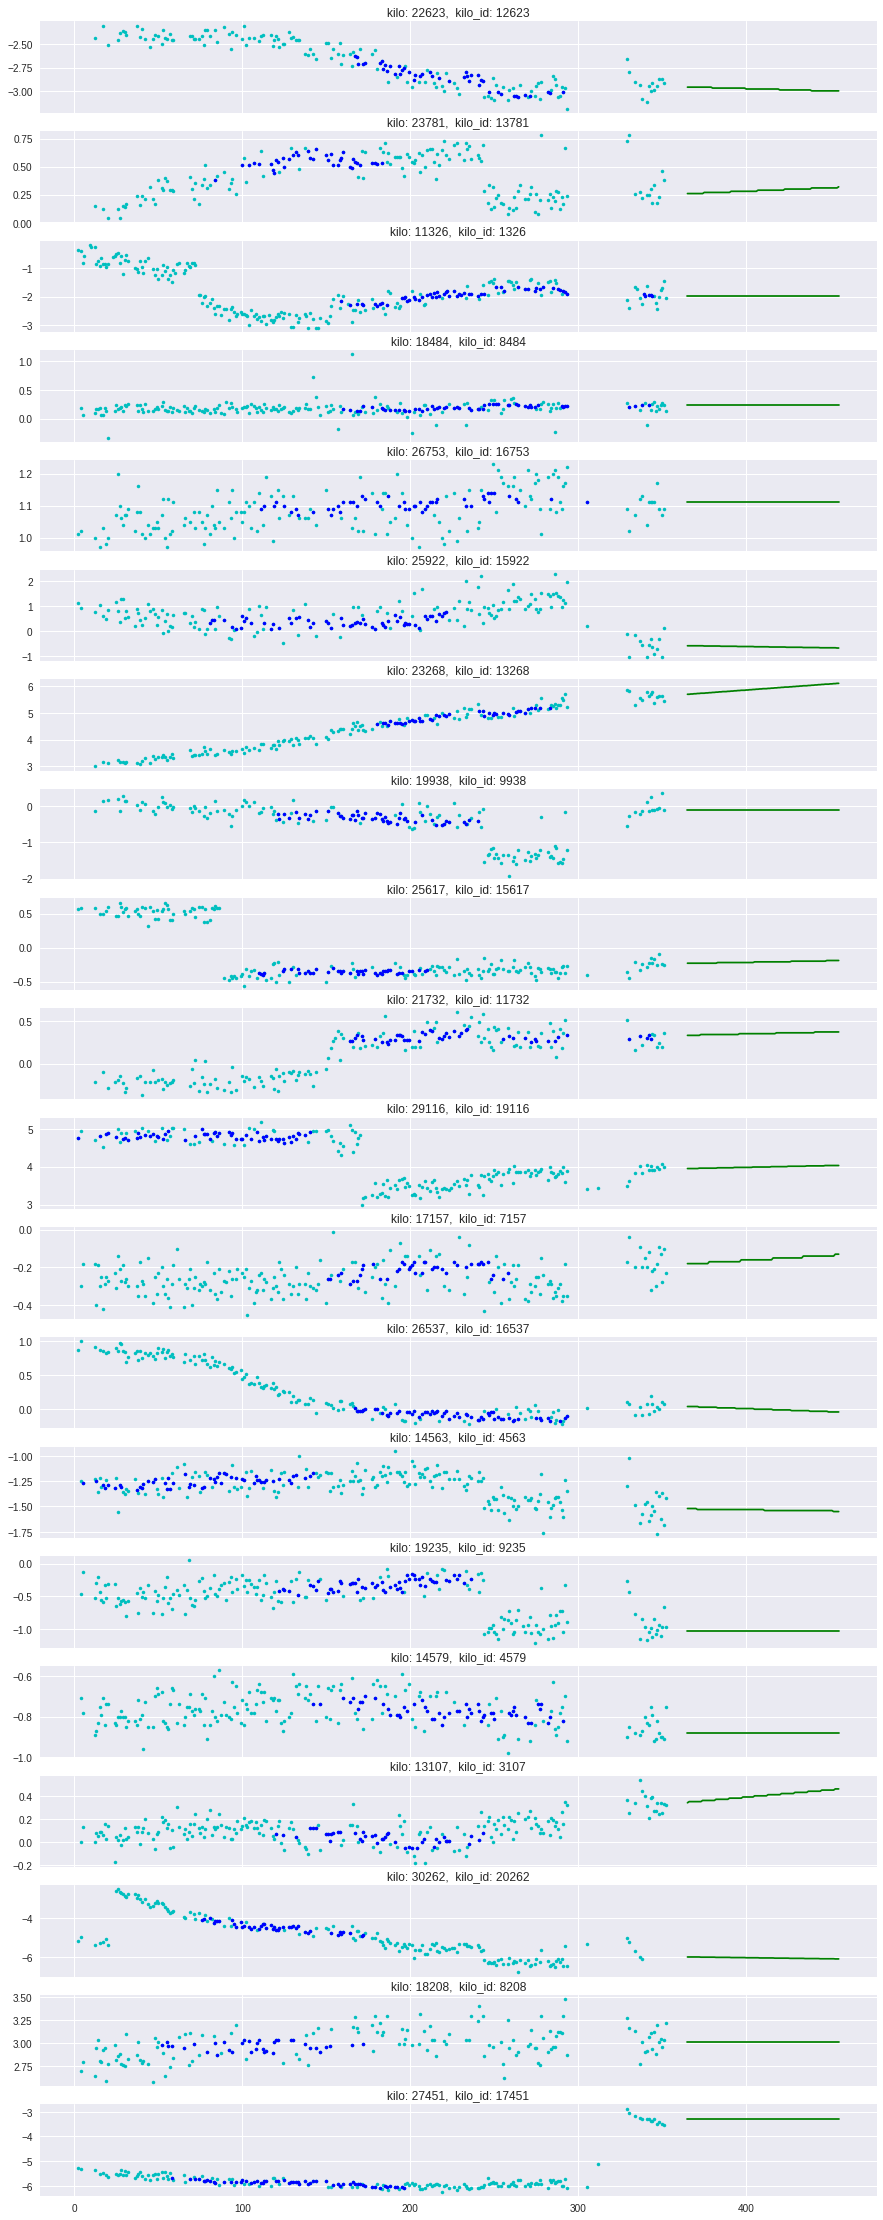

In [0]:
random.seed(0)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['B']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    hoge = np.array(hoge) + len(tracks['A']['キロ程'].unique())*91
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

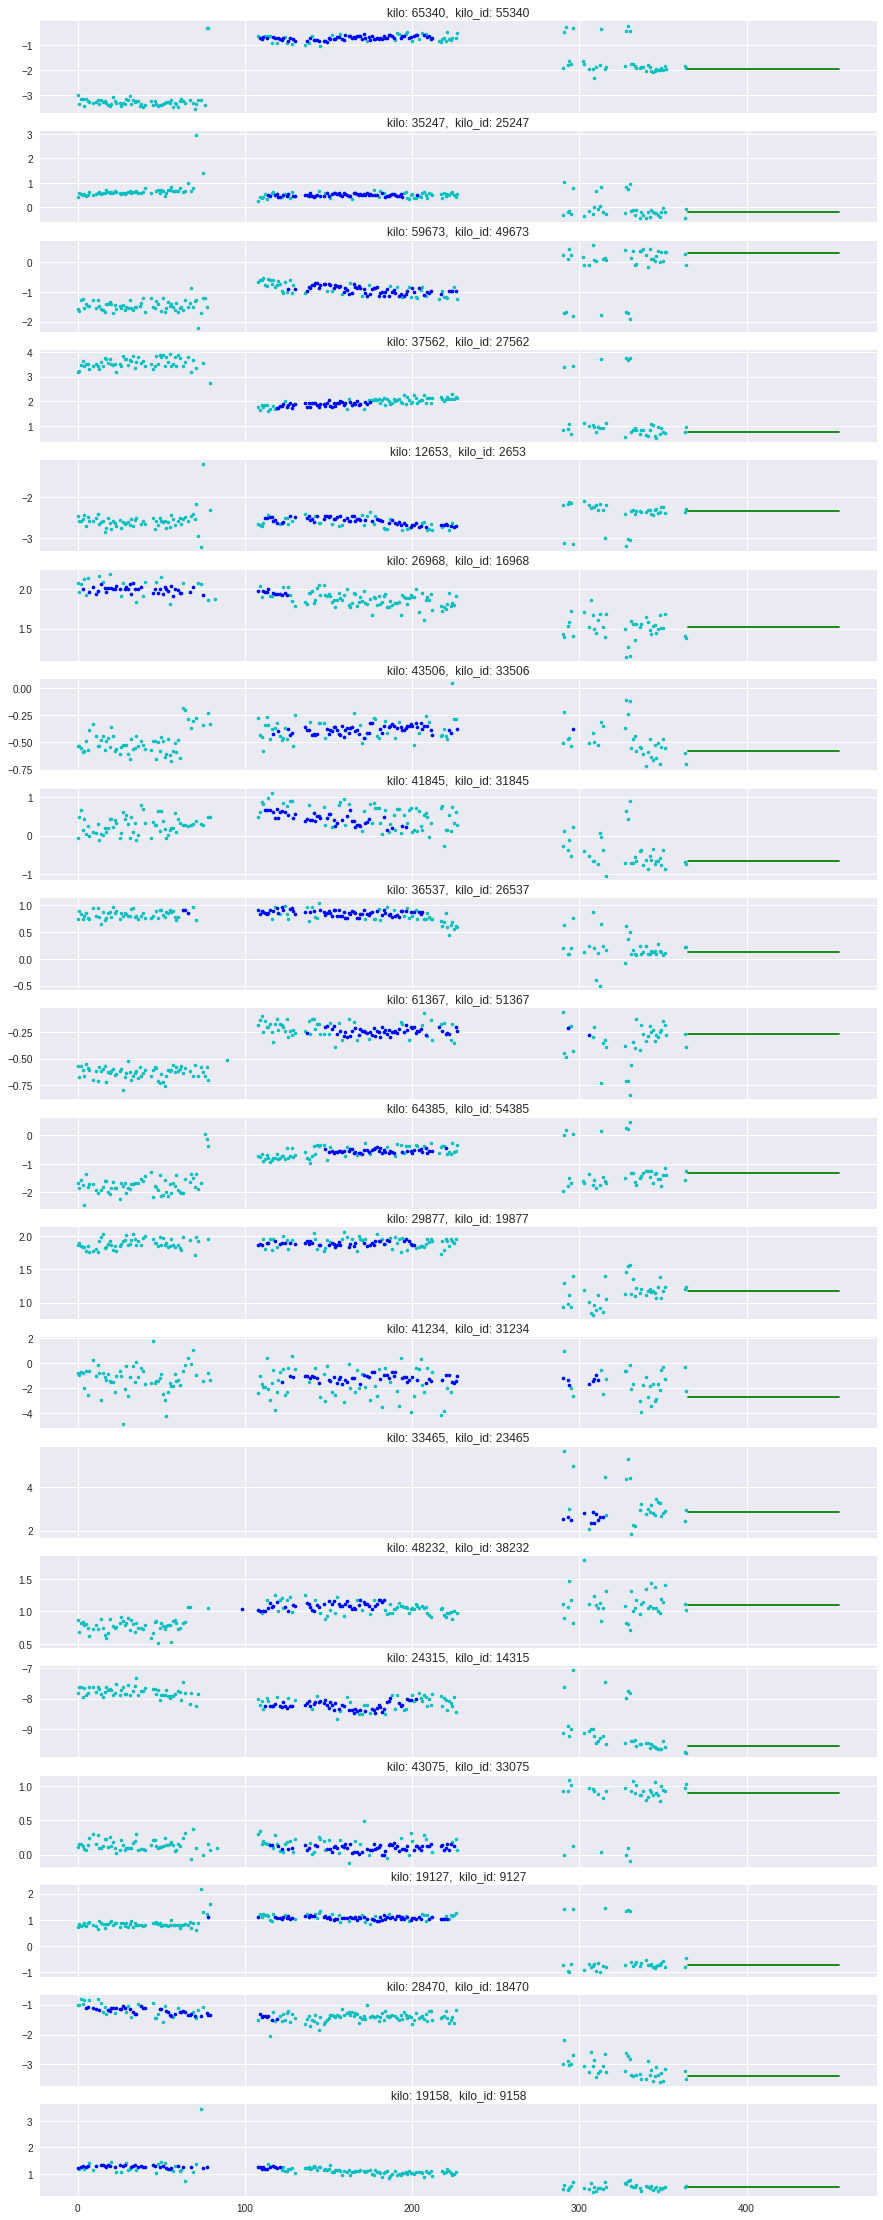

In [0]:
random.seed(0)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['C']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    hoge = np.array(hoge) + len(tracks['A']['キロ程'].unique())*91 + len(tracks['B']['キロ程'].unique())*91
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

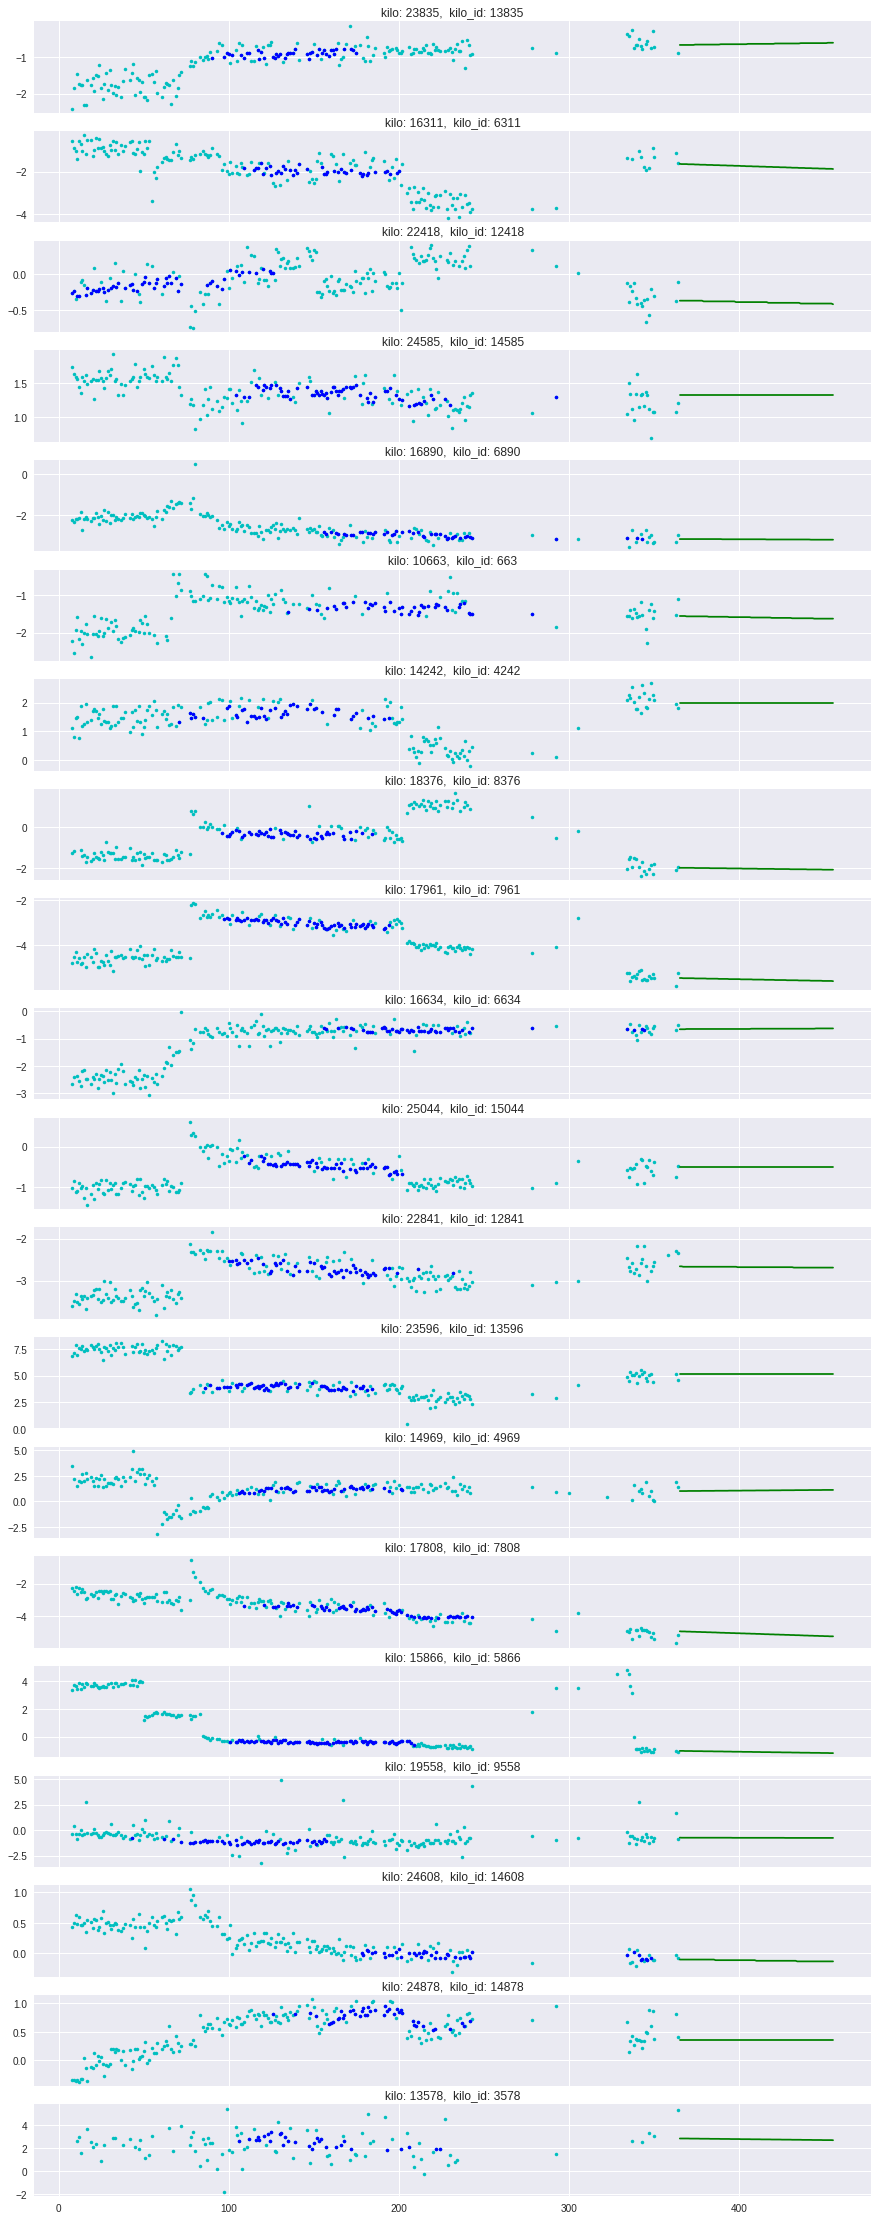

In [0]:
random.seed(0)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['D']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    hoge = np.array(hoge) + len(tracks['A']['キロ程'].unique())*91 + len(tracks['B']['キロ程'].unique())*91 + len(tracks['C']['キロ程'].unique())*91
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')